Importação livrarias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

Importação dos dados

In [ ]:
treino0 = pd.read_csv("petr4_treinamento.csv")
treino0 = treino0.dropna()
teste0 = pd.read_csv("petr4_teste.csv")

xtreino = treino0.iloc[:,1:2].values
xteste = teste0.iloc[:,1:2].values

xtreino

array([[19.99    ],
       [19.809999],
       [20.33    ],
       ...,
       [15.99    ],
       [16.1     ],
       [16.1     ]])

Normalização dos dados

In [ ]:
sc = MinMaxScaler()

xtreino = sc.fit_transform(xtreino)
xteste = sc.transform(xteste)

Criação das dimensões necessárias para o LSTM

Para a entrada do LSTM, as dimensões tem que ser (entradas, dias_atras, saídas)

In [ ]:
x = []
y = []

dias_atras = 30
tamanho_x = xtreino.shape[0]

for i in range(dias_atras, tamanho_x):
  x.append(
      xtreino[i-dias_atras:i,0]
  )
  y.append(
      xtreino[i,0]
  )
x, y = np.array(x), np.array(y)

x = np.reshape(x, (x.shape[0], x.shape[1], 1))

Vamos transformar também a base de teste

In [ ]:
x_geral = np.concatenate((xtreino, xteste), axis=0)

xt = []
yt = []
tsize = xteste.shape[0]

for i in range((x_geral.shape[0]-tsize), x_geral.shape[0]):
  xt.append(
      x_geral[i-dias_atras:i,0]
  )
xt, yt = np.array(xt), np.array(yt)
xt = np.reshape(xt, (xt.shape[0], xt.shape[1], 1))

Criação do modelo

In [ ]:
modelo = Sequential()

modelo.add(LSTM(
    units = 100,
    return_sequences = True,
    input_shape = (x.shape[1], 1)
))
modelo.add(Dropout(0.2))

modelo.add(LSTM(
    units = 50,
    return_sequences = True
))
modelo.add(Dropout(0.2))


modelo.add(LSTM(
    units = 50,
    return_sequences = True
))
modelo.add(Dropout(0.2))


modelo.add(LSTM(
    units = 50
))
modelo.add(Dropout(0.2))


modelo.add(Dense(
    units = 1,
    activation = "linear"
))

modelo.compile(
    optimizer = "rmsprop",
    loss = "mean_squared_error",
    metrics = ["mean_absolute_error"]
)

In [ ]:
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 100)           40800     
                                                                 
 dropout_8 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 30, 50)            30200     
                                                                 
 dropout_9 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

Treinamento do modelo

In [ ]:
cb = [
      ModelCheckpoint(
          monitor = "val_loss",
          filepath = "modelo_petrobras.keras",
          save_best_only = True
      )
]

history = modelo.fit(x,y,
                     batch_size = 16,
                     epochs = 100,
                     callbacks = cb,
                     validation_data = (xt, xteste))

Epoch 1/100
76/76 [==============================] - 11s 65ms/step - loss: 0.0249 - mean_absolute_error: 0.1169 - val_loss: 0.0457 - val_mean_absolute_error: 0.2105
Epoch 2/100
76/76 [==============================] - 3s 46ms/step - loss: 0.0125 - mean_absolute_error: 0.0870 - val_loss: 0.0394 - val_mean_absolute_error: 0.1955
Epoch 3/100
76/76 [==============================] - 3s 45ms/step - loss: 0.0090 - mean_absolute_error: 0.0732 - val_loss: 7.7429e-04 - val_mean_absolute_error: 0.0250
Epoch 4/100
76/76 [==============================] - 4s 47ms/step - loss: 0.0078 - mean_absolute_error: 0.0684 - val_loss: 0.0238 - val_mean_absolute_error: 0.1518
Epoch 5/100
76/76 [==============================] - 4s 46ms/step - loss: 0.0065 - mean_absolute_error: 0.0618 - val_loss: 0.0061 - val_mean_absolute_error: 0.0764
Epoch 6/100
76/76 [==============================] - 3s 46ms/step - loss: 0.0062 - mean_absolute_error: 0.0597 - val_loss: 0.0027 - val_mean_absolute_error: 0.0466
Epoch 7/100

Ver o gráfico de loss

Text(0.5, 1.0, 'erro')

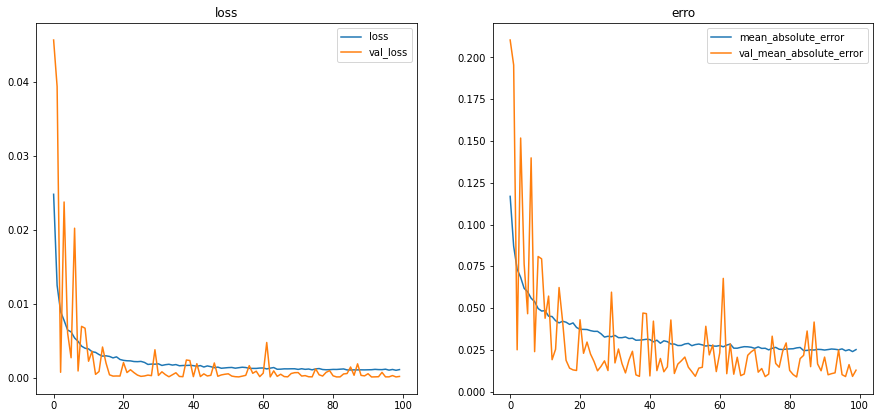

In [ ]:
h = history.history

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(h["loss"])
plt.plot(h["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("loss")
plt.subplot(2,2,2)
plt.plot(h["mean_absolute_error"])
plt.plot(h["val_mean_absolute_error"])
plt.legend(["mean_absolute_error", "val_mean_absolute_error"])
plt.title("erro")

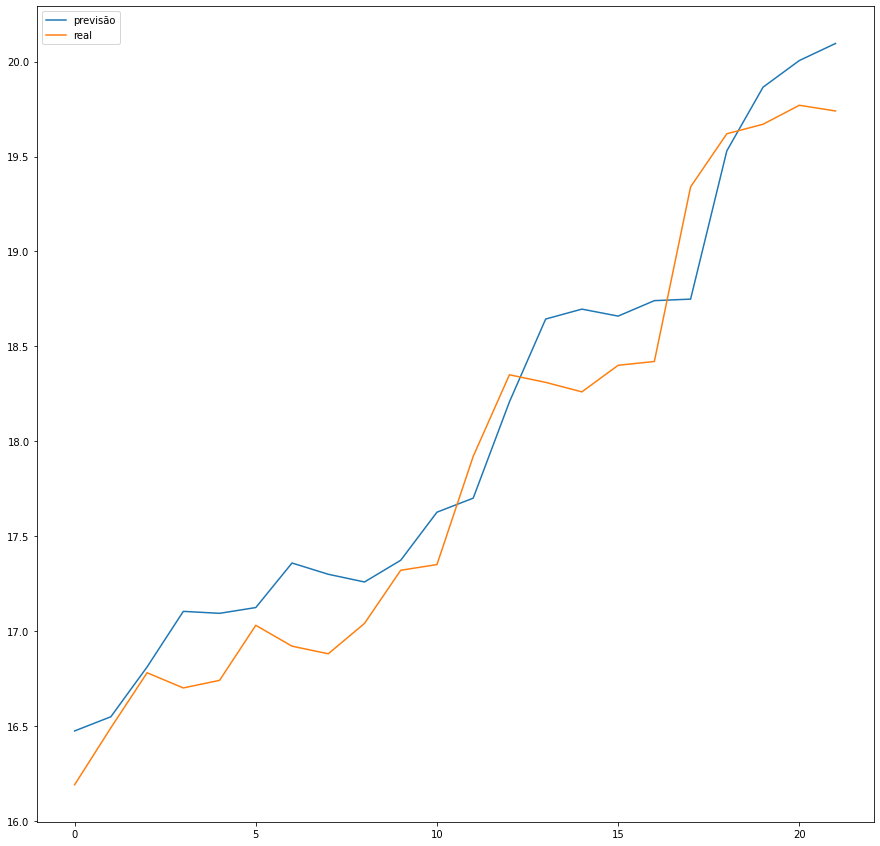

In [ ]:
resultado = sc.inverse_transform(modelo.predict(xt))
plt.figure(figsize=(15,15))
plt.plot(resultado)
plt.plot(sc.inverse_transform(xteste))
plt.legend(["previsão", "real"])
plt.show()